---
title: Linear Convection with JAX - Part I
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

In this tutorial, we will go over the simple 1D Linear Convection scheme. We will break down how we solve the PDE into abstractions. For each of these abstractions so that we can see how we can think in the Jax context. At the end of the tutorial, we will have an implementation within the JAX context.


Summary of Steps:

* 1D Linear Convection PDE
* Forward-Time-Backwards-Space (FTBS)
* Simple Time Stepper - Euler
* Break Problem into chunks
* Jax-ified Version
    * Functional
    * Explicit Types

In [23]:
import sys

from pyprojroot import here


# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [24]:
import jax
import jax.numpy as jnp
import kernex as kex
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jaxtyping import Array, Float, PyTree
from tqdm.notebook import tqdm


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PDE: 1D Linear Convection

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$ (pde)

For the PDE {eq}`pde`, we are going to do a backwards difference discretization in space and a forwards in time. It is given by:

$$
u_{i}^{n+1} = u_{i}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (discretization_full)

In [25]:
# PDE params
c = 1.0
sigma = 1.0

# spatial discretization
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)
x_grid = np.linspace(xmin, xmax, nx)

# temporal discretization
t0 = 0.0
tmax = 0.5

### CFL Condition

This is necessary for convergence.

$$
\sigma = \frac{c\Delta t}{\Delta x} \leq 1
$$ (cfl_advection)

So rearranging, we can find the correct time step given the CFL condition.

$$
\Delta t = \frac{\sigma\Delta x}{c} \leq 1
$$ (cfl_advection_dt)

In [26]:
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c


sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)

time_steps = np.arange(t0, tmax, dt)

print(f"Δt = {dt:.4f}")

Δt = 0.0082


In [27]:
solns = dict()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [28]:
# initialize field to be zero
u_init = np.ones((nx,))
u_init[int(0.5 / dx) : int(1 / dx + 1)] = 2.0

u = u_init.copy()


for t in tqdm(time_steps):
    # copy to avoid overwriting

    # calculate the terms
    u[1:] = u[1:] - c * (dt / dx) * (u[1:] - u[:-1])

    # boundaries
    u[0] = 1.0
    u[-1] = 1.0


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()
solns["numpy"] = u

  0%|          | 0/62 [00:00<?, ?it/s]

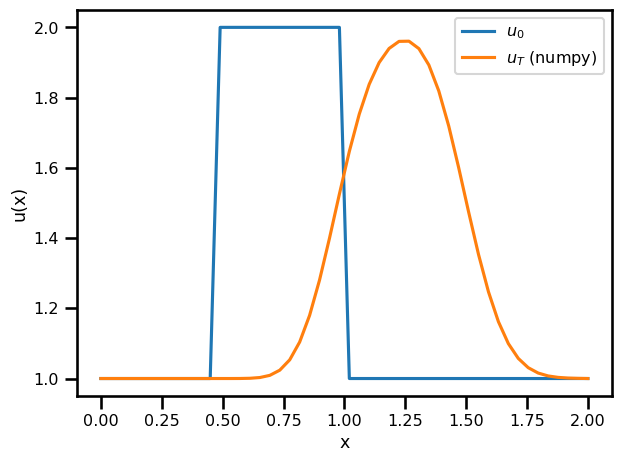

In [29]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label=r"$u_0$")
ax.plot(x_grid, solns["numpy"], label="$u_T$ (numpy)")
ax.set(
    xlabel="x",
    ylabel="u(x)",
)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# initialize field to be zero
u_init = jnp.ones((nx,), dtype=jnp.float32)
u_init = u_init.at[int(0.5 / dx) : int(1 / dx + 1)].set(2.0)
u = u_init.copy()

for t in tqdm(time_steps):
    # # loops (BUG!)
    # for i in range(1, u.shape[0]-1):
    #     u = u.at[i].set(u[i] - c * (dt/dx) * (u[i] - u[i-1]))

    # numpy-like
    u = u.at[1:].set(u[1:] - c * (dt / dx) * (u[1:] - u[:-1]))

    u = u.at[0].set(1.0)
    u = u.at[-1].set(1.0)


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()
solns["jax"] = u

  0%|          | 0/62 [00:00<?, ?it/s]

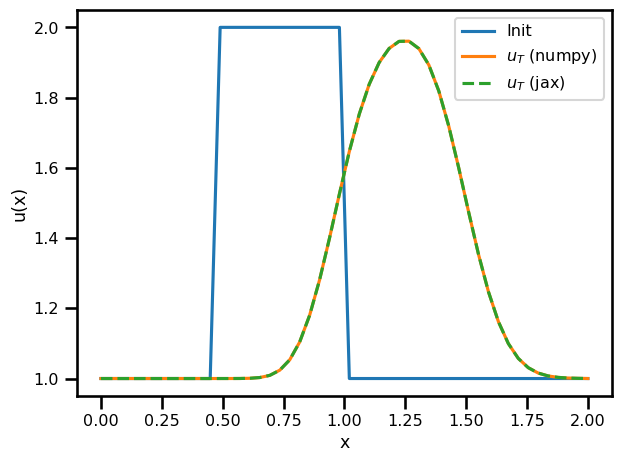

In [31]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label="Init")
ax.plot(x_grid, solns["numpy"], label="$u_T$ (numpy)", linestyle="-")
ax.plot(x_grid, solns["jax"], label="$u_T$ (jax)", linestyle="--")
ax.set(
    xlabel="x",
    ylabel="u(x)",
)
plt.legend()
plt.tight_layout()
plt.show()

## Jax-ify

Now, we should jax-ify all of the things. The biggest thing is that everything should be *somewhat* funtional.

---
**Components**

There are definitely some components here that I can identify from the above code.

* Initialization Function
* RHS Function (including FD Operator)
* Boundary Conditions
* Step Function

## Discretization

### Spatial

So all spatial discretizations are like so:

$$
x \in \Omega \sub \mathbb{R}^{D}
$$ (spatial_d)

Where:

* $\mathbb{R}^D$ - the space of coordinates, e.g. Euclidean, Spherical, and the size, e.g. scalar, vector, etc
* $\Omega$ - the domain and discretization (if any)

Let's define it first intuitively, and then we will revisit the notation.

In [32]:
# spatial discretization
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)

# spatial grid
x_grid = np.linspace(xmin, xmax, nx)

# check dx
assert x_grid[1] - x_grid[0] == dx
print(f"Δx: {dx:.4f}")

Δx: 0.0408


So the space, $\mathbb{R}^D$, is actually $\mathbb{R}$ because we are on a 1D line. 

The domain, $\Omega$, is bounded between 0 and 2 (by our choosing). The discretization, $\Delta x$, is the interval of points on the bounded number line. So ours is $\Delta x\approx0.04$.

### Temporal

All temporal discretizations are like so

$$
t \in \mathcal{T} \sub \mathbb{R}^+
$$ (time_d)

The space of time coordinates live on a linearly increasing line of integers. But we're interested in a bounded domain, $\mathcal{T}$. Usually, this is defined as $\mathcal{T}=[0,T]$ and this is actually what we do here. 

In [33]:
# temporal discretization
t0 = 0.0
tmax = 0.5

# CFL Conditions
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)


# Temporal Grid
time_steps = np.arange(t0, tmax, dt)

### Initialization Function

In functional terms, we can define the initialization as:

$$
\mathcal{IC}[u](x,0) = 
\begin{cases}
2 & \text{where } 0.5 \leq x \leq 1,\\
1 & \text{everywhere else in } (0,2) \\
\end{cases}
$$ (ic)

In practical terms, we need to initialize our state, $u$, based on the domain and discretization, $\Omega$.

$$
\mathcal{IC}[u](x,0):= \boldsymbol{IC}(\Omega, x)
$$ (ic_practical)

In [34]:
# initialize field to be zero


def init_u_fn(grid: Float[Array, "D"]) -> Float[Array, "D"]:
    """Initial condition from grid"""
    u = jnp.ones_like(grid, dtype=jnp.float64)

    u = u.at[int(0.5 / dx) : int(1 / dx + 1)].set(2.0)

    return u

### Boundary Conditions

For the boundary conditions, this is another function that is dependent upon the domain and discretization. It can be defined as:

$$
\mathcal{BC}[u](x, t) = 1.0, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)

In practical terms, we want to apply some function, $\boldsymbol{b}$, which modifies our state, $u$, at the coordinates along the boundaries of the domain, i.e. $x \in \partial\Omega$. In our case it is constant. But we can easily think of strategies where it is an actual function.

In [35]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    u = u.at[0].set(1.0)

    u = u.at[-1].set(1.0)

    # TODO: can use where based on points
    return u

### RHS

So for this, the right-hand side is the following

$$
\mathcal{RHS}[u]:=\mathcal{F}[u;\theta](x) = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (rhs)

We also can see that we can abstract the backwards finite difference operator as well.

$$
\begin{aligned}
\mathcal{F}[u] &= - c \cdot \mathcal{N}[u](x) \hspace{10mm} x\in\Omega \\
\mathcal{N}[u]:=\mathcal{N}_{BD}[u] &= \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right) \\
\end{aligned}
$$ (rhs_complete)

#### Finite Difference Operator

$$
\mathcal{N}_{BD}[u] = \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (bd)

In [36]:
# 1st order backwards finite difference operator


@kex.kmap(kernel_size=(2,), padding="valid", relative=True, named_axis={0: "i"})
def fd_back(u: Float[Array, "2"], dx: PyTree[float]) -> Float[Array, ""]:
    return (u["i+1"] - u["i"]) / dx

Notice for the named axis, I use the "i+1" and "i". It's equivalent to "i" and "i-1". It just depends on the starting point.

$$
u_i - u_{i-1} = u_{i+1} - u_i
$$

#### Final RHS

In [37]:
from jaxsw._src.operators.functional.fd import difference


# RHS function
def rhs_fn(
    u: Float[Array, "D"], dx: PyTree[float], c: PyTree[float]
) -> Float[Array, "D"]:
    """RHS for 1D Advection.
    Uses a Backwards FD scheme
    """
    #     # removes artefact from stencil operation
    #     u = jnp.pad(u, pad_width=((1,0)), mode="edge")

    #     # FD
    #     u = fd_back(u, dx)

    u = difference(u, axis=0, accuracy=1, step_size=dx, derivative=1, method="backward")

    # constant
    u = -c * u

    return u


out = rhs_fn(u_init, dx=dx, c=c)

### Step Function

Now, we want to put all of this together. So we're going to create a step function that will allow us to take a state, $u$, apply the FD operator, apply the boundary conditions, return the RHS, and step forward one iteration in time. 

The most general form of this step function is

$$
u_{t+1} = u_t + \boldsymbol{g}(u_t, t)
$$ (step_fn_general)
which basically says that "the next state is the current state plus something". There are many such time-steppers in the literature ranging from Taylor-based schemes (e.g. Euler) to quadrature schemes (e.g. Runga-Kutta). All have pros and cons and we can spend a long time trying to look at all of them. For this example, we will use a simple Euler time stepper.

$$
u_{t+1} = u_t + \Delta t \boldsymbol{f}(u_t)
$$ (step)

It's not the best, but it is fine for a simple problem. 


So we can write a general step of operations for the Stepper as well.

$$

\mathcal{RHS}[u]:= 
\begin{cases}
\mathcal{F}[u] & x\in\Omega\\
\mathcal{B}[u] & x\in\partial\Omega \\
\end{cases}
$$ (stepper)

In [38]:
def step_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    # apply bcs for current state
    u = bc_fn(u)

    # calculate RHS
    rhs = rhs_fn(u, dx, c)

    # time step
    u = u + dt * rhs

    return u


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()

### Jax Bonus: Jitting

To make all things go *brrrr*, we can compile the function using the `jax.jit` command, aka just-in-time (JIT). Because we have written this in such a way that everything is functional, we should have no problem in fusing all of the operations and compiling it down to XLA code. This will make things go much faster.

**Note 1**: I recommend undoing the `jit` compilations when you are debugging. 

**Note 2**: There is some debate but in general, try to only `jit` the **final** operation you wish to use. It often doesn't always achieve any more speedups when you `jit` every individual function. Plus when debugging, you can simply undo the final *jitted* function instead of all of the underlying *jitted* functions in your code.

In [39]:
step_fn_jitted = jax.jit(step_fn)

We can even time it.

In [40]:
u = init_u_fn(x_grid)

n_step = %timeit -o step_fn(u).block_until_ready()
j_step = %timeit -o step_fn_jitted(u).block_until_ready()

2.21 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.56 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
print(f"Time: {n_step.average:.4e} secs")
print(f"Time (Jitted): {j_step.average:.4e} secs")
speedup = n_step.average / j_step.average
print(f"Speedup: x{speedup:_.0f}")

Time: 2.2093e-03 secs
Time (Jitted): 3.5598e-06 secs
Speedup: x621


In [42]:
# initialize u from grid
u = init_u_fn(x_grid)

# loop through time steps
for t in tqdm(time_steps):
    # # normal step
    # u = step_fn(u)

    # Jitted step
    u = step_fn_jitted(u)

solns["jaxify"] = u

  0%|          | 0/62 [00:00<?, ?it/s]

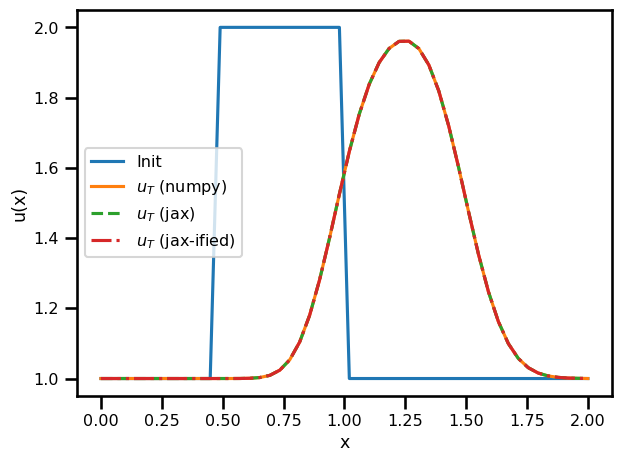

In [43]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init, label="Init")
ax.plot(x_grid, solns["numpy"], label="$u_T$ (numpy)", linestyle="-")
ax.plot(x_grid, solns["jax"], label="$u_T$ (jax)", linestyle="--")
ax.plot(x_grid, solns["jaxify"], label="$u_T$ (jax-ified)", linestyle="-.")
ax.set(
    xlabel="x",
    ylabel="u(x)",
)
plt.legend()
plt.tight_layout()
plt.show()